In [ ]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install publicsuffix2
%pip install playwright

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-

In [1]:
import json 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from urllib.parse import urlparse
import glob
from collections import Counter, defaultdict
from publicsuffix2 import get_sld
import os
import re
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [115]:
services_path='../services.json'
site_lists='../sites_list.csv'

# ## 1. Data Loading and Setup

In [ ]:
class CrawlAnalyzer:
    def __init__(self, services_file=services_path):
        self.load_disconnect_data(services_file)
        
    def load_disconnect_data(self, services_file):
        """Load Disconnect services data"""
        with open(services_file, 'r') as f:
            self.services = json.load(f)
        
        # Build domain to entity mapping
        self.domain_to_entity = {}
        self.domain_categories = defaultdict(set)
        
        for category in self.services['categories']:
            for entity_list in self.services['categories'][category]:
                for entity_name, entity_data in entity_list.items():
                    for url_pattern, domains in entity_data.items():
                        for domain in domains:
                            self.domain_to_entity[domain] = entity_name
                            self.domain_categories[domain].add(category)
    
    def parse_har_file(self, har_path):
        """Parse HAR file and extract relevant data"""
        try:
            with open(har_path, 'r', encoding='utf-8') as f:
                har_data = json.load(f)
        except Exception as e:
            print(f"Error reading {har_path}: {e}")
            return pd.DataFrame()
        
        entries = []
        website_domain = Path(har_path).stem
        
        for entry in har_data['log']['entries']:
            request = entry['request']
            response = entry['response']
            
            # Skip blocked/empty responses as per requirements
            if response['status'] == 0 or response.get('content', {}).get('size', 0) == 0:
                continue
                
            url = request['url']
            parsed_url = urlparse(url)
            domain = get_sld(parsed_url.netloc) if parsed_url.netloc else ''
            
            if not domain:
                continue
                
            # Determine if third-party
            website_sld = get_sld(website_domain)
            is_third_party = domain != website_sld and not domain.endswith('.' + website_sld)
            
            entry_data = {
                'website': website_domain,
                'url': url,
                'domain': domain,
                'is_third_party': is_third_party,
                'status': response['status'],
                'size': response.get('content', {}).get('size', 0)
            }
            
            # Extract headers
            response_headers = {h['name'].lower(): h['value'] for h in response.get('headers', [])}
            request_headers = {h['name'].lower(): h['value'] for h in request.get('headers', [])}
            
            entry_data['response_headers'] = response_headers
            entry_data['request_headers'] = request_headers
            
            # Add entity information
            entry_data['entity'] = self.domain_to_entity.get(domain, 'Unknown')
            entry_data['categories'] = list(self.domain_categories.get(domain, set()))
            
            entries.append(entry_data)
        
        return pd.DataFrame(entries)

# Check available crawl data

In [117]:
analyzer = CrawlAnalyzer(services_path)

crawl_modes = ['accept', 'reject', 'block']
# available_data = {}

# for mode in crawl_modes:
#     har_files = glob.glob(f"../har_logs_{mode}/*.har")
#     available_data[mode] = len(har_files)
#     print(f"Found {len(har_files)} HAR files for {mode} mode")

In [118]:

crawl_data = {}
for mode in crawl_modes:
    print(f"Processing {mode} mode...")
    all_data = []
    har_files = glob.glob(f"../har_logs_{mode}/*.har")
    
    for har_file in har_files:
        df = analyzer.parse_har_file(har_file)
        if not df.empty:
            df['crawl_mode'] = mode
            all_data.append(df)
    
    if all_data:
        crawl_data[mode] = pd.concat(all_data, ignore_index=True)
        print(f"Loaded {len(crawl_data[mode])} requests from {crawl_data[mode]['website'].nunique()} websites")
    else:
        crawl_data[mode] = pd.DataFrame()
        print(f"No data found for {mode} mode")

Processing accept mode...
Loaded 38328 requests from 36 websites
Processing reject mode...
Loaded 15893 requests from 40 websites
Processing block mode...
Loaded 16054 requests from 40 websites


In [ ]:
#crawl_data['accept'].head()
#crawl_data['reject'].head()
#crawl_data['block'].head()

,website,url,domain,is_third_party,status,size,response_headers,request_headers,entity,categories,crawl_mode
0,ad.nl,https://ad.nl/,ad.nl,False,301,-1,"{'connection': 'keep-alive', 'content-length':...","{'accept': 'text/html,application/xhtml+xml,ap...",Unknown,[],accept
1,ad.nl,https://www.ad.nl/,ad.nl,False,302,-1,"{'accept-ch': 'sec-ch-ua-model,sec-ch-ua-platf...","{':authority': 'www.ad.nl', ':method': 'GET', ...",Unknown,[],accept
2,ad.nl,https://myprivacy.dpgmedia.nl/consent?siteKey=...,dpgmedia.nl,True,200,7861,"{'alt-svc': 'h3="":443""; ma=93600', 'cache-cont...","{':authority': 'myprivacy.dpgmedia.nl', ':meth...",Unknown,[],accept
3,ad.nl,https://myprivacy-static.dpgmedia.net/consent.js,dpgmedia.net,True,200,254247,"{'content-encoding': 'gzip', 'etag': '""79853ba...","{'sec-ch-ua-platform': '""Windows""', 'referer':...",Unknown,[],accept
4,ad.nl,https://myprivacy-static.dpgmedia.net/consent/...,dpgmedia.net,True,200,5701,"{'accept-ranges': 'bytes', 'access-control-all...",{':authority': 'myprivacy-static.dpgmedia.net'...,Unknown,[],accept


In [ ]:
# for mode, data in crawl_data.items():
#     if not data.empty:
#         print(f"\n{mode.upper()} MODE:")
#         print(f"Total requests: {len(data):,}")
#         print(f"Websites crawled: {data['website'].nunique()}")
#         print(f"Third-party requests: {data['is_third_party'].sum():,} ({data['is_third_party'].mean():.1%})")
#         print(f"Unique domains: {data['domain'].nunique()}")
#         print(f"Unique entities: {data[data['entity'] != 'Unknown']['entity'].nunique()}")


ACCEPT MODE:
Total requests: 38,328
Websites crawled: 36
Third-party requests: 33,335 (87.0%)
Unique domains: 671
Unique entities: 245

REJECT MODE:
Total requests: 15,893
Websites crawled: 40
Third-party requests: 11,223 (70.6%)
Unique domains: 433
Unique entities: 133

BLOCK MODE:
Total requests: 16,054
Websites crawled: 40
Third-party requests: 10,216 (63.6%)
Unique domains: 404
Unique entities: 120


#### 1: Boxplot Comparison

In [10]:
def calculate_basic_metrics(df):
    """Calculate metrics for Q1 and Q2"""
    if df.empty:
        return pd.DataFrame()
        
    metrics = df.groupby('website').agg({
        'url': 'count',  # Total requests
        'is_third_party': 'sum',  # Third-party requests
    }).rename(columns={
        'url': 'total_requests',
        'is_third_party': 'third_party_requests',
    })
    
    # Distinct third-party domains
    third_party_domains = df[df['is_third_party']].groupby('website')['domain'].nunique()
    metrics['distinct_third_party_domains'] = third_party_domains
    
    # Distinct entities
    distinct_entities = df[df['is_third_party']].groupby('website')['entity'].apply(
        lambda x: x[x != 'Unknown'].nunique()
    )
    metrics['distinct_entities'] = distinct_entities
    
    return metrics.fillna(0)

In [ ]:
print("Calculating metrics for each crawl mode...")
metrics = {}
for mode in crawl_modes:
    if not crawl_data[mode].empty:
        metrics[mode] = calculate_basic_metrics(crawl_data[mode])
        print(f"{mode}: {len(metrics[mode])} websites")


Calculating metrics for each crawl mode...
accept: 36 websites
reject: 40 websites
block: 40 websites


# Create boxplots for Question 1

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_28868\1643335294.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(plot_data, labels=labels, patch_artist=True)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_28868\1643335294.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(plot_data, labels=labels, patch_artist=True)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_28868\1643335294.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(plot_data, labels=labels, patch_artist=True)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_28868\1643335294.py:24: M

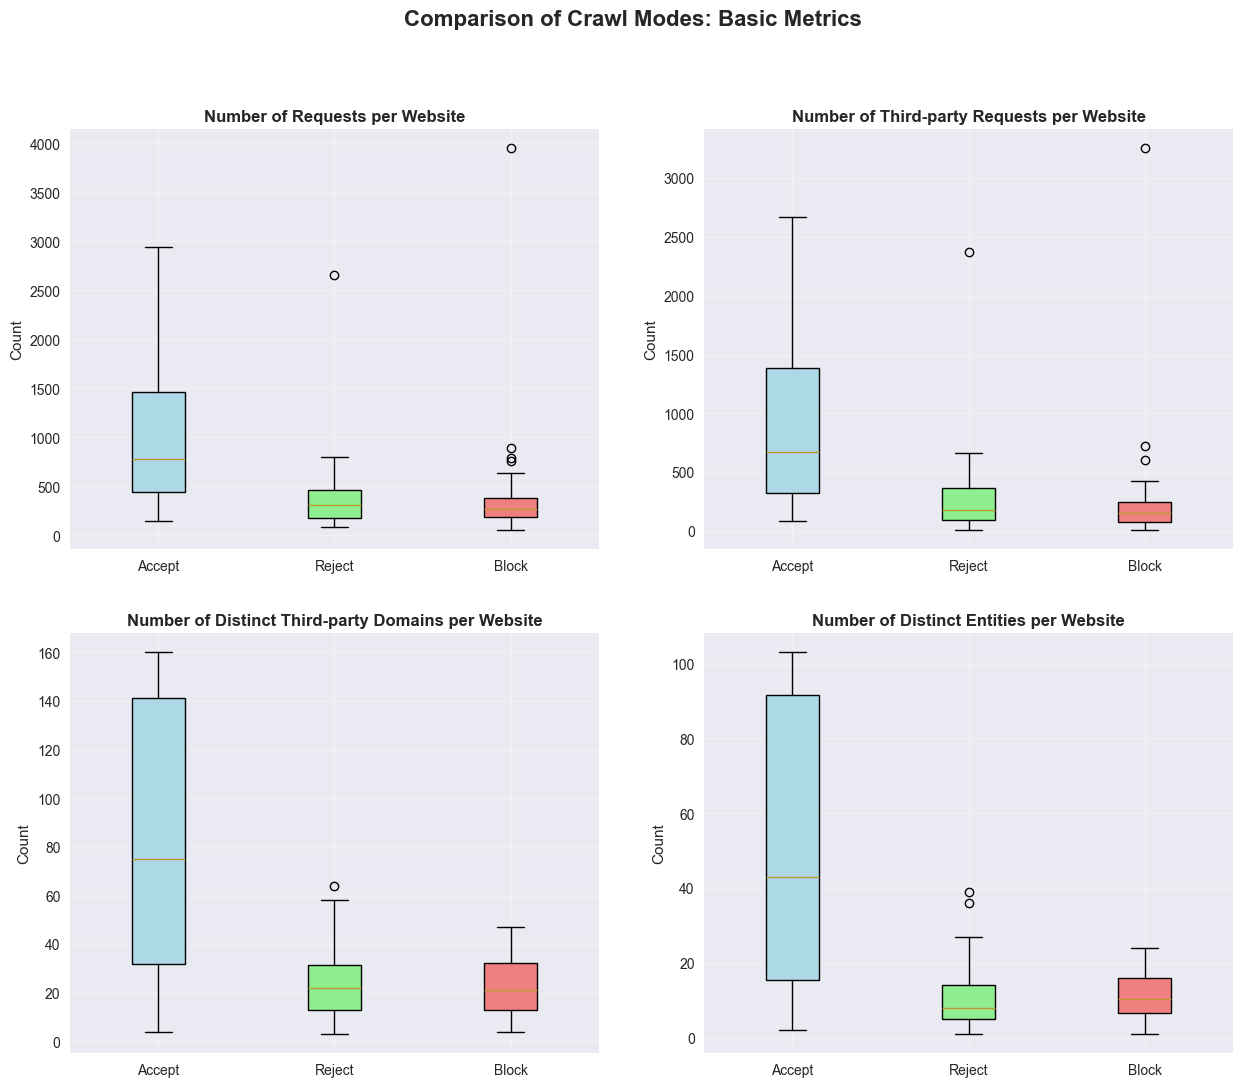

In [116]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparison of Crawl Modes: Basic Metrics', fontsize=16, fontweight='bold')

metric_configs = [
    ('total_requests', 'Number of Requests per Website'),
    ('third_party_requests', 'Number of Third-party Requests per Website'),
    ('distinct_third_party_domains', 'Number of Distinct Third-party Domains per Website'),
    ('distinct_entities', 'Number of Distinct Entities per Website')
]

for idx, (metric, title) in enumerate(metric_configs):
    ax = axes[idx//2, idx%2]
    
    plot_data = []
    labels = []
    for mode in crawl_modes:
        if mode in metrics and not metrics[mode].empty and metric in metrics[mode].columns:
            data = metrics[mode][metric].dropna()
            if len(data) > 0:
                plot_data.append(data)
                labels.append(mode.capitalize())
    
    if plot_data:
        boxplot = ax.boxplot(plot_data, labels=labels, patch_artist=True)
        # Color the boxes
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        for patch, color in zip(boxplot['boxes'], colors):
            patch.set_facecolor(color)
        
        ax.set_title(title, fontweight='bold')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)
 
plt.show()

#### 2:

In [41]:
comparison_data = []
metrics_list = ['total_requests', 'third_party_requests', 
               'distinct_third_party_domains', 'distinct_entities']

for metric in metrics_list:
    row = {'Metric': metric.replace('_', ' ').title()}
    
    for mode in crawl_modes:
        if mode in metrics and not metrics[mode].empty and metric in metrics[mode].columns:
            data = metrics[mode][metric].dropna()
            if len(data) > 0:
                row[f'{mode}_min'] = data.min()
                row[f'{mode}_median'] = data.median()
                row[f'{mode}_max'] = data.max()
                row[f'{mode}_mean'] = data.mean()
            else:
                row.update({f'{mode}_min': 0, f'{mode}_median': 0, f'{mode}_max': 0, f'{mode}_mean': 0})
        else:
            row.update({f'{mode}_min': 0, f'{mode}_median': 0, f'{mode}_max': 0, f'{mode}_mean': 0})
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("Comparison Table:")
display(comparison_df.round(1))

Comparison Table:


,Metric,accept_min,accept_median,accept_max,accept_mean,reject_min,reject_median,reject_max,reject_mean,block_min,block_median,block_max,block_mean
0,Total Requests,151,777.5,2939,1064.7,82,306.5,2655,397.3,54,272.0,3950,401.4
1,Third Party Requests,85,668.0,2672,926.0,11,178.5,2373,280.6,6,150.0,3254,255.4
2,Distinct Third Party Domains,4,75.0,160,83.5,3,22.0,64,24.3,4,21.0,47,22.4
3,Distinct Entities,2,43.0,103,49.9,1,8.0,39,11.3,1,10.5,24,11.4


#### 3

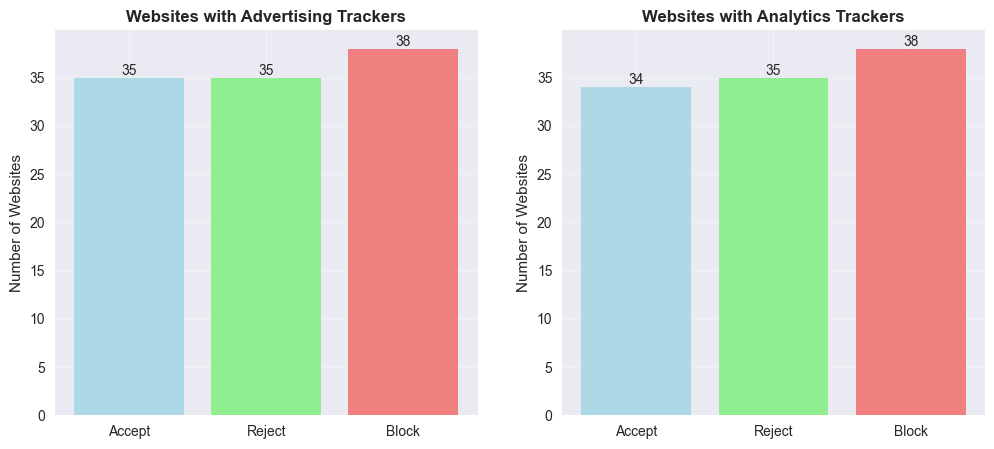

In [ ]:
def analyze_tracking_categories(df, mode_name):
    """Analyze websites with at least one request to tracking categories"""
    if df.empty:
        return {'Advertising': 0, 'Analytics': 0}
    
    websites_with_ads = set()
    websites_with_analytics = set()
    
    for website, website_data in df.groupby('website'):
        # Get all unique categories requested by this website
        all_categories = set()
        for _, row in website_data.iterrows():
            all_categories.update(row.get('categories', []))
        
        # Check if website contacted tracking domains
        if 'Advertising' in all_categories:
            websites_with_ads.add(website)
        if 'Analytics' in all_categories:
            websites_with_analytics.add(website)
    
    return {
        'Advertising': len(websites_with_ads),
        'Analytics': len(websites_with_analytics)
    }

tracking_results = {}
for mode in crawl_modes:
    if not crawl_data[mode].empty:
        tracking_results[mode] = analyze_tracking_categories(crawl_data[mode], mode)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ad_data = [tracking_results.get(mode, {}).get('Advertising', 0) for mode in crawl_modes]
bars1 = ax1.bar([m.capitalize() for m in crawl_modes], ad_data, color=['lightblue', 'lightgreen', 'lightcoral'])
ax1.set_title('Websites with Advertising Trackers', fontweight='bold')
ax1.set_ylabel('Number of Websites')
ax1.grid(True, alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

analytics_data = [tracking_results.get(mode, {}).get('Analytics', 0) for mode in crawl_modes]
bars2 = ax2.bar([m.capitalize() for m in crawl_modes], analytics_data, color=['lightblue', 'lightgreen', 'lightcoral'])
ax2.set_title('Websites with Analytics Trackers', fontweight='bold')
ax2.set_ylabel('Number of Websites')
ax2.grid(True, alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.show()

#### 4: US vs European News Sites Comparison

In [121]:
def load_country_mappings(site_list_path=site_lists):
    
    site_list_df = pd.read_csv(site_list_path)
    domain_to_country = dict(zip(site_list_df['domain'], site_list_df['country']))
    return domain_to_country
    
def get_country_code(website, domain_to_country):
    website_lower = website.lower()
    
   
    if domain_to_country and website_lower in domain_to_country:
        return domain_to_country[website_lower]
    
    # # Second try: Partial match (e.g., "www.nos.nl" matches "nos.nl")
    # if domain_to_country:
    #     for domain, country in domain_to_country.items():
    #         if domain in website_lower:
    #             return country
    

def analyze_us_vs_european_with_site_list(accept_data, site_list_path=site_lists):
    if accept_data.empty:
        return pd.DataFrame(), pd.DataFrame()
    
    domain_to_country = load_country_mappings(site_list_path)
    
    us_websites = []
    european_websites = []
    other_websites = []
    
    for website in accept_data['website'].unique():
        country = get_country_code(website, domain_to_country)
        
        if country == 'us':
            us_websites.append(website)
        elif country in ['nl', 'de', 'fr', 'it', 'uk', 'es', 'be']:  # European countries
            european_websites.append(website)
        else:
            other_websites.append(website)
    
    us_data = accept_data[accept_data['website'].isin(us_websites)]
    european_data = accept_data[accept_data['website'].isin(european_websites)]
    
    print(f"US sites (site-list classification): {len(us_websites)} websites")
    print(f"European sites (site-list classification): {len(european_websites)} websites")
    print(f"Other sites: {len(other_websites)} websites")
    
    us_metrics = calculate_basic_metrics(us_data)
    european_metrics = calculate_basic_metrics(european_data)
    
    return us_metrics, european_metrics, us_data, european_data, us_websites, european_websites

if 'accept' in crawl_data and not crawl_data['accept'].empty:
    (us_metrics, european_metrics, us_data, european_data, 
     us_websites, european_websites) = analyze_us_vs_european_with_site_list(crawl_data['accept'])
    
    comparison_data = []
    metrics_list = ['total_requests', 'third_party_requests', 
                   'distinct_third_party_domains', 'distinct_entities']
    
    for metric in metrics_list:
        row = {'Metric': metric.replace('_', ' ').title()}
        
        if not us_metrics.empty and metric in us_metrics.columns:
            us_data_metric = us_metrics[metric].dropna()
            if len(us_data_metric) > 0:
                row['US_Min'] = us_data_metric.min()
                row['US_Median'] = us_data_metric.median()
                row['US_Max'] = us_data_metric.max()
                row['US_Mean'] = us_data_metric.mean()
            else:
                row.update({'US_Min': 0, 'US_Median': 0, 'US_Max': 0, 'US_Mean': 0})
        else:
            row.update({'US_Min': 0, 'US_Median': 0, 'US_Max': 0, 'US_Mean': 0})
        
        # European metrics
        if not european_metrics.empty and metric in european_metrics.columns:
            eu_data_metric = european_metrics[metric].dropna()
            if len(eu_data_metric) > 0:
                row['European_Min'] = eu_data_metric.min()
                row['European_Median'] = eu_data_metric.median()
                row['European_Max'] = eu_data_metric.max()
                row['European_Mean'] = eu_data_metric.mean()
            else:
                row.update({'European_Min': 0, 'European_Median': 0, 'European_Max': 0, 'European_Mean': 0})
        else:
            row.update({'European_Min': 0, 'European_Median': 0, 'European_Max': 0, 'European_Mean': 0})
        
        comparison_data.append(row)
    
    us_eu_comparison_df = pd.DataFrame(comparison_data)
    display(us_eu_comparison_df.round(1))

US sites (site-list classification): 16 websites
European sites (site-list classification): 20 websites
Other sites: 0 websites


,Metric,US_Min,US_Median,US_Max,US_Mean,European_Min,European_Median,European_Max,European_Mean
0,Total Requests,530,1215.0,2484,1274.4,151,506.5,2939,896.8
1,Third Party Requests,222,1061.0,2448,1107.3,85,437.0,2672,780.9
2,Distinct Third Party Domains,25,102.0,155,98.6,4,58.0,160,71.4
3,Distinct Entities,7,59.5,100,59.0,2,28.0,103,42.7


In [ ]:
comparison_data = []
metrics_list = ['total_requests', 'third_party_requests', 
               'distinct_third_party_domains', 'distinct_entities']

for metric in metrics_list:
    row = {'Metric': metric.replace('_', ' ').title()}
    
    for mode in crawl_modes:
        if mode in metrics and not metrics[mode].empty and metric in metrics[mode].columns:
            data = metrics[mode][metric].dropna()
            if len(data) > 0:
                row[f'{mode}_min'] = data.min()
                row[f'{mode}_median'] = data.median()
                row[f'{mode}_max'] = data.max()
                row[f'{mode}_mean'] = data.mean()
            else:
                row.update({f'{mode}_min': 0, f'{mode}_median': 0, f'{mode}_max': 0, f'{mode}_mean': 0})
        else:
            row.update({f'{mode}_min': 0, f'{mode}_median': 0, f'{mode}_max': 0, f'{mode}_mean': 0})
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("Comparison Table:")
display(comparison_df.round(1))


Creating comparison table...
Comparison Table:


,Metric,accept_min,accept_median,accept_max,accept_mean,reject_min,reject_median,reject_max,reject_mean,block_min,block_median,block_max,block_mean
0,Total Requests,151,777.5,2939,1064.7,82,306.5,2655,397.3,54,272.0,3950,401.4
1,Third Party Requests,85,668.0,2672,926.0,11,178.5,2373,280.6,6,150.0,3254,255.4
2,Distinct Third Party Domains,4,75.0,160,83.5,3,22.0,64,24.3,4,21.0,47,22.4
3,Distinct Entities,2,43.0,103,49.9,1,8.0,39,11.3,1,10.5,24,11.4


#### 5: Advertising and Analytics Tracking


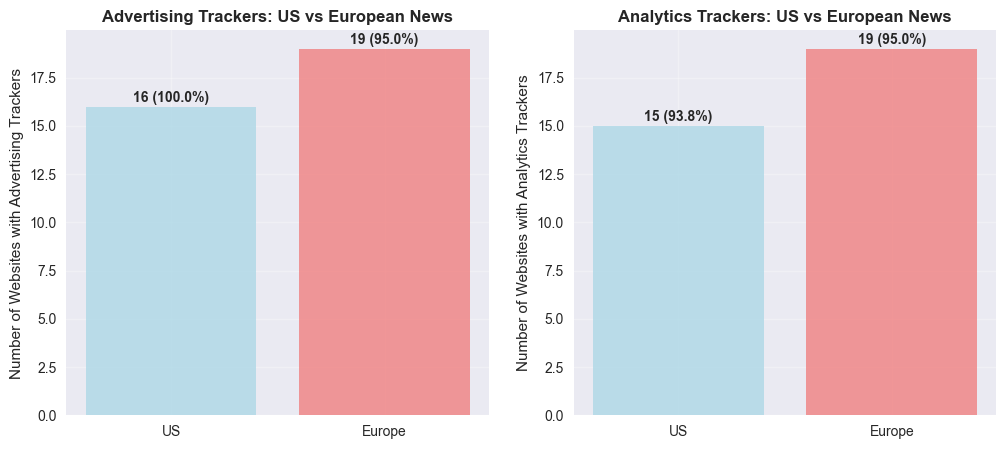

In [ ]:
def analyze_region_tracking_categories(us_data, european_data):
    
    # Analyze tracking categories for both regions
    us_tracking = analyze_tracking_categories(us_data, 'US News')
    eu_tracking = analyze_tracking_categories(european_data, 'European News')
    
   
    region_results = {
        'US': {
            'Advertising': us_tracking['Advertising'],
            'Analytics': us_tracking['Analytics'],
            'total_websites': us_data['website'].nunique()
        },
        'Europe': {
            'Advertising': eu_tracking['Advertising'],
            'Analytics': eu_tracking['Analytics'],
            'total_websites': european_data['website'].nunique()
        }
    }
    
    return region_results

def create_region_tracking_plot(region_results):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    regions = ['US', 'Europe']
    colors = ['lightblue', 'lightcoral']
    
   
    ad_data = [region_results[region]['Advertising'] for region in regions]
    analytics_data = [region_results[region]['Analytics'] for region in regions]
    total_websites = [region_results[region]['total_websites'] for region in regions]
    
   
    ad_percentages = [ (ad_data[i] / total_websites[i]) * 100 if total_websites[i] > 0 else 0 
                      for i in range(len(regions)) ]
    analytics_percentages = [ (analytics_data[i] / total_websites[i]) * 100 if total_websites[i] > 0 else 0 
                             for i in range(len(regions)) ]
    
    # Plot 5a: Advertising comparison
    bars1 = ax1.bar(regions, ad_data, color=colors, alpha=0.8)
    ax1.set_title('Advertising Trackers: US vs European News', fontweight='bold')
    ax1.set_ylabel('Number of Websites with Advertising Trackers')
    ax1.grid(True, alpha=0.3)
    
    
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)} ({ad_percentages[i]:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')
    
    # Plot 5b: Analytics comparison  
    bars2 = ax2.bar(regions, analytics_data, color=colors, alpha=0.8)
    ax2.set_title('Analytics Trackers: US vs European News', fontweight='bold')
    ax2.set_ylabel('Number of Websites with Analytics Trackers')
    ax2.grid(True, alpha=0.3)
    
    
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)} ({analytics_percentages[i]:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')
    
   
region_tracking_results = analyze_region_tracking_categories(us_data, european_data)
create_region_tracking_plot(region_tracking_results)
    


####  6: JS-cookies

In [ ]:
def _parse_cookie_header(raw):
   
    if not raw:
        return []

    # Normalise – header can be a single string or a list of strings
    values = raw if isinstance(raw, list) else [raw]

    names = []
    for v in values:
        parts = re.split(r';\s*(?=\w+=)', str(v).strip())
        for part in parts:
            if '=' in part:
                name = part.split('=', 1)[0].strip()
                # Skip attributes that are not real cookies
                if name and name.lower() not in {
                    'path', 'domain', 'expires', 'max-age',
                    'secure', 'httponly', 'samesite'
                }:
                    names.append(name)
    return names


def _same_site(website, request_domain):
    
    def base(host):
        h = host.replace('http://', '').replace('https://', '').split('/')[0]
        parts = h.split('.')
        return '.'.join(parts[-2:]) if len(parts) >= 2 else h

    return base(website) == base(request_domain)


def js_cookie_report(accept_df: pd.DataFrame) -> pd.DataFrame:
    """
    Only cookies that:
        -  appear in a request Cookie header
        -  were not sent back by the server in a Set-Cookie header
        -  belong to the same site 
    """
    results = []

 
    for website, site_df in accept_df.groupby('website'):

        # ---- 1. Collect every cookie the *server* ever set for this site
        server_set = set()
        for _, row in site_df.iterrows():
            hdr = row.get('response_headers', {})
            if 'set-cookie' in hdr:
                server_set.update(_parse_cookie_header(hdr['set-cookie']))

        # ---- 2. Walk through every request and look for unknown cookies
        for _, row in site_df.iterrows():
            hdr = row.get('request_headers', {})
            domain = row['domain']                    

            if 'cookie' not in hdr:
                continue

            req_cookies = _parse_cookie_header(hdr['cookie'])
            for name in req_cookies:
                if name not in server_set and _same_site(website, domain):
                    results.append({
                        'cookie_name' : name,
                        'website'     : website,
                        'cookie_domain': domain
                    })

    df = pd.DataFrame(results)

    df = df.drop_duplicates()

    # Remove cookies that appear on more than 3 different sites – they are almost
    # always third-party trackers, not JS-created first-party cookies.
    common = df['cookie_name'].value_counts()
    df = df[~df['cookie_name'].isin(common[common > 1].index)]

    df = df.sort_values(['website', 'cookie_name']).reset_index(drop=True)
    return df

if 'accept' in crawl_data and not crawl_data['accept'].empty:
    report = js_cookie_report(crawl_data['accept'])

    print(f"client-side JavaScript cookies: {len(report)}")
    display(report.head(50))




#####  7:  most prevalent third-party domains

In [103]:

for mode in crawl_modes:
    if mode in crawl_data and not crawl_data[mode].empty:
        # Create prevalence table
        prevalence_table = (crawl_data[mode][crawl_data[mode]['is_third_party']]
                           .groupby('domain')
                           .agg({'website': 'nunique', 'categories': 'first'})
                           .rename(columns={'website': 'Number of distinct websites'})
                           .sort_values('Number of distinct websites', ascending=False)
                           .head(10)
                           .reset_index()
                           .rename(columns={'domain': 'Third-party domain'}))
        
        # Format categories
        prevalence_table['Disconnect categories'] = prevalence_table['categories'].apply(
            lambda x: ', '.join(x) if isinstance(x, list) and x else 'NA'
        )
        prevalence_table = prevalence_table.drop('categories', axis=1)
        
        print(f"\n{mode.upper()} MODE:")
        display(prevalence_table)
        # prevalence_table.to_csv(f'q8_{mode}_prevalence.csv', index=False)


ACCEPT MODE:


,Third-party domain,Number of distinct websites,Disconnect categories
0,doubleclick.net,32,"Email, FingerprintingGeneral, Advertising"
1,google.com,32,Content
2,googlesyndication.com,31,"FingerprintingGeneral, Advertising"
3,adnxs.com,30,Advertising
4,amazon-adsystem.com,29,Advertising
5,adtrafficquality.google,28,Advertising
6,gstatic.com,27,Content
7,adsrvr.org,27,"FingerprintingGeneral, Advertising"
8,criteo.com,26,Advertising
9,casalemedia.com,26,Advertising



REJECT MODE:


,Third-party domain,Number of distinct websites,Disconnect categories
0,googlesyndication.com,27,"FingerprintingGeneral, Advertising"
1,googletagmanager.com,25,NA
2,doubleclick.net,24,"Email, FingerprintingGeneral, Advertising"
3,fonts.googleapis.com,22,NA
4,google.com,20,Content
5,gstatic.com,19,Content
6,amazon-adsystem.com,18,Advertising
7,adtrafficquality.google,17,Advertising
8,scorecardresearch.com,13,Analytics
9,google-analytics.com,12,"Email, FingerprintingGeneral, Analytics"



BLOCK MODE:


,Third-party domain,Number of distinct websites,Disconnect categories
0,doubleclick.net,30,"Email, FingerprintingGeneral, Advertising"
1,google.com,27,Content
2,amazon-adsystem.com,24,Advertising
3,googletagmanager.com,23,NA
4,googlesyndication.com,17,"FingerprintingGeneral, Advertising"
5,scorecardresearch.com,17,Analytics
6,fonts.googleapis.com,15,NA
7,gstatic.com,15,Content
8,chartbeat.com,12,Analytics
9,facebook.net,12,"Social, FingerprintingGeneral"


##### 8: highest number of distinct third-party domains

In [ ]:
def websites_analysis(crawl_data, crawl_modes, top_n=10):
    
    domain_to_country = load_country_mappings(site_lists)
    
    all_results = {}
    
    for mode in crawl_modes:
        if mode in crawl_data and not crawl_data[mode].empty:
            website_table = (crawl_data[mode][crawl_data[mode]['is_third_party']]
                           .groupby('website')
                           .agg({'domain': 'nunique'})
                           .rename(columns={'domain': 'Number of distinct third-party domains'})
                           .sort_values('Number of distinct third-party domains', ascending=False)
                           .head(top_n)
                           .reset_index()
                           .rename(columns={'website': 'Website'}))
            
            website_table['Country code'] = website_table['Website'].apply(
                lambda x: get_country_code(x, domain_to_country)
            )
            
            website_table = website_table[['Website', 'Country code', 'Number of distinct third-party domains']]
            
            all_results[mode] = website_table
            
            display(website_table)
           
    
    return all_results


results = websites_analysis(crawl_data, crawl_modes, top_n=10)

Loaded 40 country mappings from ../sites_list.csv


,Website,Country code,Number of distinct third-party domains
0,dailymail.co.uk,uk,160
1,nltimes.nl,nl,158
2,corriere.it,it,158
3,gazzetta.it,it,158
4,huffpost.com,us,155
5,newsweek.com,us,153
6,apnews.com,us,152
7,nypost.com,us,143
8,reuters.com,us,142
9,the-sun.com,uk,141


,Website,Country code,Number of distinct third-party domains
0,nbcnews.com,us,64
1,msnbc.com,us,58
2,newsweek.com,us,54
3,apnews.com,us,52
4,nltimes.nl,nl,43
5,businessinsider.com,us,43
6,wsj.com,us,43
7,corriere.it,it,39
8,nypost.com,us,36
9,huffpost.com,us,33


,Website,Country code,Number of distinct third-party domains
0,nypost.com,us,47
1,corriere.it,it,38
2,gazzetta.it,it,37
3,cnn.com,us,36
4,cbsnews.com,us,35
5,wsj.com,us,35
6,dailymail.co.uk,uk,35
7,bloomberg.com,us,34
8,nbcnews.com,us,33
9,reuters.com,us,33


#### 9: highest number of distinct server IP addresses per website

In [ ]:
def server_ip_analysis(crawl_data, crawl_modes, top_n=10):

    
    domain_to_country = load_country_mappings(site_lists)
    
    all_data = []
    
    for mode in crawl_modes:
        if mode in crawl_data and not crawl_data[mode].empty:
            df = crawl_data[mode]
            
            # Count distinct domains per website (as proxy for server IPs)
            stats = (df.groupby('website')
                    .agg({'domain': 'nunique'})
                    .reset_index()
                    .rename(columns={'domain': 'ip_count'}))
            
            stats['Crawl type'] = mode.capitalize()
            

            stats['Country code'] = stats['website'].apply(
                lambda x: get_country_code(x, domain_to_country)
            )
            
            all_data.append(stats)
    
    if not all_data:
        return pd.DataFrame()
    
    
    combined = pd.concat(all_data, ignore_index=True)
    top_visits = (combined.sort_values('ip_count', ascending=False)
                  .head(top_n)
                  .reset_index(drop=True))
    
    # Create final table
    result = top_visits[['website', 'Crawl type', 'Country code']].copy()
    result['Number of distinct server IPs ↓'] = top_visits['ip_count']
    result = result.rename(columns={'website': 'Website'})
   
    return result

server_ip_analysis(crawl_data, crawl_modes)

Loaded 40 country mappings from ../sites_list.csv


,Website,Crawl type,Country code,Number of distinct server IPs ↓
0,dailymail.co.uk,Accept,uk,161
1,corriere.it,Accept,it,159
2,gazzetta.it,Accept,it,159
3,nltimes.nl,Accept,nl,159
4,huffpost.com,Accept,us,156
5,newsweek.com,Accept,us,154
6,apnews.com,Accept,us,153
7,nypost.com,Accept,us,144
8,reuters.com,Accept,us,143
9,the-sun.com,Accept,uk,142


##### 10:  Permissions-Policy 

In [ ]:
def permissions_analysis(crawl_data, crawl_modes):
    
    def parse_policy(header_value):
       
        if not header_value:
            return []
        
        disabled = []
        try:
            if isinstance(header_value, list):
                header_value = ' '.join(header_value)
            
            patterns = [
                r'(\w+)=\(\)',           
                r"(\w+)='none'",        
                r'(\w+)=""',            
            ]
            
            for pattern in patterns:
                matches = re.findall(pattern, header_value)
                disabled.extend(matches)
                
        except Exception as e:
            pass  
            
        return disabled
    
    all_results = {}
    
    for mode in crawl_modes:
        if mode not in crawl_data or crawl_data[mode].empty:
            continue
            
        print(f"Processing {mode} mode...")
        df = crawl_data[mode]
        
        permission_counts = {}
        websites_with_policy = 0
        
        for website, website_data in df.groupby('website'):
            website_disabled = set()
            
            for _, row in website_data.iterrows():
                headers = row.get('response_headers', {})
                
                # Check for policy headers
                for header_name, header_value in headers.items():
                    if 'permissions-policy' in header_name.lower() or 'feature-policy' in header_name.lower():
                        disabled_perms = parse_policy(header_value)
                        website_disabled.update(disabled_perms)
            
            if website_disabled:
                websites_with_policy += 1
                for perm in website_disabled:
                    permission_counts[perm] = permission_counts.get(perm, 0) + 1
        
        all_results[mode] = {
            'permission_counts': permission_counts,
            'websites_with_policy': websites_with_policy,
            'total_websites': df['website'].nunique()
        }
    
    return all_results

def create_table(results, crawl_modes, top_n=5):
    
    all_perms = set()
    for mode in crawl_modes:
        if mode in results:
            all_perms.update(results[mode]['permission_counts'].keys())
    
    perm_totals = {}
    for perm in all_perms:
        total = 0
        for mode in crawl_modes:
            if mode in results:
                total += results[mode]['permission_counts'].get(perm, 0)
        perm_totals[perm] = total
    
    top_perms = sorted(perm_totals.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    table_data = []
    for perm, _ in top_perms:
        row = {'Permission': perm}
        for mode in crawl_modes:
            count = results.get(mode, {}).get('permission_counts', {}).get(perm, 0)
            row[mode.capitalize()] = count
        table_data.append(row)
    
    return pd.DataFrame(table_data)


simple_results = permissions_analysis(crawl_data, crawl_modes)

if simple_results:
    table = create_table(simple_results, crawl_modes)
    
    print("\nRESULTS:")
    print(f"{'Permission':<20} {'Accept':<8} {'Reject':<8} {'Block':<8}")
    print("-" * 50)
    
    for _, row in table.iterrows():
        print(f"{row['Permission']:<20} {row['Accept']:<8} {row['Reject']:<8} {row['Block']:<8}")
    


SIMPLE PERMISSIONS-POLICY ANALYSIS
Processing accept mode...
Processing reject mode...
Processing block mode...

RESULTS:
Permission           Accept   Reject   Block   
--------------------------------------------------
cohort               15       10       5       
camera               18       8        3       
geolocation          18       8        3       
microphone           17       8        2       
midi                 15       8        3       


#### 11: Referrer-Policy 

In [ ]:
def quick_referrer_analysis(crawl_data, crawl_modes):
    """Quick analysis focusing on the main non-default policies"""
    
    target_policies = ['no-referrer', 'same-origin', 'unsafe-url', 'strict-origin']
    
    results = {mode: {p: 0 for p in target_policies} for mode in crawl_modes}
    
    for mode in crawl_modes:
        if mode not in crawl_data or crawl_data[mode].empty:
            continue
            
        df = crawl_data[mode]
        
        for website, website_data in df.groupby('website'):
            found_policies = set()
            
            for _, row in website_data.iterrows():
                headers = row.get('response_headers', {})
                
                for header_name, header_value in headers.items():
                    if 'referrer-policy' in header_name.lower():
                        policy = str(header_value).strip().lower()
                        if policy in target_policies:
                            found_policies.add(policy)
            
            for policy in found_policies:
                results[mode][policy] += 1
    
    # Display results
   
    print(f"{'Referrer Policy':<20} {'Crawl-Accept':<15} {'Crawl-Reject':<15} {'Crawl-Block':<15}")
    print("-" * 70)
    
    for policy in target_policies:
        accept = results.get('accept', {}).get(policy, 0)
        reject = results.get('reject', {}).get(policy, 0)
        block = results.get('block', {}).get(policy, 0)
        print(f"{policy:<20} {accept:<15} {reject:<15} {block:<15}")
    
    return results

quick_results = quick_referrer_analysis(crawl_data, crawl_modes)

Referrer Policy      Crawl-Accept    Crawl-Reject    Crawl-Block    
----------------------------------------------------------------------
no-referrer          6               3               2              
same-origin          5               4               4              
unsafe-url           3               3               3              
strict-origin        1               1               1              
